# Model Training
For reference see [Finetuning Torchvision Models](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)  

***
# Setup

In [1]:
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.append(os.path.expanduser('~/mount_sinai_health_hackathon_ekg_img/'))
from common_code import *
%matplotlib inline

from sklearn.metrics import confusion_matrix

import torchvision.models as models
from torchvision import datasets, transforms
# from sklearn.metrics import confusion_matrix

In [2]:
Dx_classes = {
'Normal': 'Normal sinus rhythm',
'AF': 'Atrial fibrillation',
'I-AVB': 'Airst-degree atrioventricular block',
'LBBB': 'Left bundle branch block',
'PAC': 'Premature atrial complex',
'PVC': 'Premature ventricular complex',
'RBBB': 'Right bundle branch block',
'STD': 'ST-segment depression',
'STE': 'ST-segment elevation',
}

In [3]:
# Check if gpu support is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device = {device}')

device = cuda


In [4]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = 'resnet'

# Number of classes in the dataset
n_classes = len(Dx_classes.keys())

# Batch size for training (change depending on how much memory you have)
batch_size = 256

# Flag for feature extraction. When True only update the reshaped layer params, when False train the whole model from scratch.
# Should probably remain True.
feature_extract = True

# use pretrained model, should probably remain True.
use_pretrained=True

# path to data dir
data_path = os.path.expanduser('~/mount_sinai_health_hackathon_ekg_img/data')

# resolution of preprocessed images
im_res = 800

In [5]:
output_path = f'../output/{model_name}'
models_path = f'../models/{model_name}'

In [6]:
# test_mem()

***
### Helper Functions

In [7]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

***
# Create the Model

In [8]:
def initialize_model(model_name, n_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0

    if model_name == 'resnet':
        ''' Resnet101
        '''
        model_ft = models.resnet101(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, n_classes)
        input_size = 224

    elif model_name == 'alexnet':
        ''' Alexnet
        '''
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,n_classes)
        input_size = 224

    elif model_name == 'vgg':
        ''' VGG11_bn
        '''
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,n_classes)
        input_size = 224

    elif model_name == 'squeezenet':
        ''' Squeezenet
        '''
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, n_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.n_classes = n_classes
        input_size = 224

    elif model_name == 'densenet':
        ''' Densenet
        '''
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, n_classes)
        input_size = 224

#    elif model_name == 'inception':
#        ''' Inception v3
#        Be careful, expects (299,299) sized images and has auxiliary output
#        '''
#        model_ft = models.inception_v3(pretrained=use_pretrained)
#        set_parameter_requires_grad(model_ft, feature_extract)
#        # Handle the auxilary net
#        num_ftrs = model_ft.AuxLogits.fc.in_features
#        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, n_classes)
#        # Handle the primary net
#        num_ftrs = model_ft.fc.in_features
#        model_ft.fc = nn.Linear(num_ftrs,n_classes)
#        input_size = 299

    else:
        raise ValueError(f'Invalid model_name = {model_name}')
        exit()

    return model_ft, input_size

In [9]:
model, input_size = initialize_model(model_name, n_classes, feature_extract, use_pretrained)

In [10]:
print(f'input_size = {input_size}')

input_size = 224


In [11]:
loss_fn = nn.CrossEntropyLoss()

model.to(device);

In [12]:
# TODO is all of this needed?

# Gather the parameters to be optimized/updated in this run.
# If we are finetuning we will be updating all parameters
# However, if we are usingthe  feature extract method, we will only update the parameters that we have just initialized,
# i.e. the parameters with requires_grad is True.

params_to_update = model.parameters()
print('Params to learn:')
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print(name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print(name)

Params to learn:
fc.weight
fc.bias


In [13]:
optimizer = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)
# optimizer = torch.optim.Adam(params_to_update, weight_decay=1e-5)

***
# Load Data

### Compute Normalization Factors

In [14]:
# use normalization results computed earlier
if input_size == 224:
    pop_mean = np.array([0.94411284, 0.94346404, 0.94239646])
    pop_std0 = np.array([0.04548508, 0.04374889, 0.04681061])
else:
    raise ValueError(f'No precomputed mean, std avalaible for input_size = {input_size}')

### Actually Load Data

In [15]:
transform = transforms.Compose([transforms.Resize(input_size), transforms.ToTensor(), transforms.Normalize(pop_mean, pop_std0)])

ds_train = tv.datasets.ImageFolder(root=f'{data_path}/preprocessed/im_res_{im_res}/train', transform=transform)
ds_val = tv.datasets.ImageFolder(root=f'{data_path}/preprocessed/im_res_{im_res}/val', transform=transform)
ds_test = tv.datasets.ImageFolder(root=f'{data_path}/preprocessed/im_res_{im_res}/test', transform=transform)

In [16]:
class_to_idx = {}
for k,v in ds_train.class_to_idx.items():
    class_to_idx[k] = v
class_to_idx = OrderedDict(sorted(class_to_idx.items(), key=lambda x: x))
idx_to_class = OrderedDict([[v,k] for k,v in class_to_idx.items()])

In [17]:
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=False, num_workers=8)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=batch_size, shuffle=False, num_workers=8)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=8)

In [18]:
# test_mem()

***
# Train

In [ ]:
# test_mem()

In [ ]:
dfp_train_results = train_model(dl_train, dl_val,
model, optimizer, loss_fn, device,
model_name=model_name, models_path=models_path,
max_epochs=200,
do_es=True, es_min_val_per_improvement=0.0005, es_epochs=10,
do_decay_lr=False, # initial_lr=0.001, lr_epoch_period=25, lr_n_period_cap=6,
)

In [ ]:
write_dfp(dfp_train_results, output_path , 'train_results', tag='',
target_fixed_cols=['epoch', 'train_loss', 'val_loss', 'best_val_loss', 'delta_per_best', 'saved_model', 'elapsed_time', 'epoch_time', 'cuda_mem_alloc'],
sort_by=['epoch'], sort_by_ascending=True)

***
# Eval

In [19]:
dfp_train_results = load_dfp(output_path, 'train_results', tag='', cols_bool=['saved_model'],
                             cols_float=['train_loss','val_loss','best_val_loss','delta_per_best','elapsed_time','epoch_time'])

In [20]:
dfp_train_results

,epoch,train_loss,val_loss,best_val_loss,delta_per_best,saved_model,elapsed_time,epoch_time,cuda_mem_alloc
0,0,2.260827,2.261052,2.261052,0.000000,True,0.566810,0.566585,193248256
1,1,2.252369,2.255964,2.255964,-0.002250,True,1.126056,0.556727,193248256
2,2,2.187448,2.188922,2.188922,-0.029718,True,1.674067,0.545534,193248256
3,3,2.191793,2.193170,2.188922,0.001941,False,2.230885,0.554200,193248256
4,4,2.148670,2.148366,2.148366,-0.018528,True,2.784918,0.554008,193248256
...,...,...,...,...,...,...,...,...,...
167,167,1.752663,1.820638,1.820638,-0.000055,True,94.136927,0.542006,193248256
168,168,1.752220,1.820540,1.820540,-0.000054,True,94.681994,0.542756,193248256
169,169,1.751779,1.820444,1.820444,-0.000053,True,95.227094,0.542798,193248256
170,170,1.751342,1.820351,1.820351,-0.000051,True,95.772778,0.543374,193248256


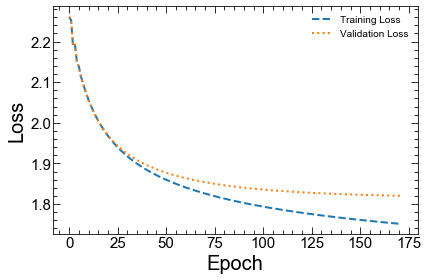

In [21]:
plot_loss_vs_epoch(dfp_train_results, output_path, fname='loss_vs_epoch', tag='', inline=True,
                   ann_text_std_add=None,
                   y_axis_params={'log': False},
                   loss_cols=['train_loss', 'val_loss'],
                  )

### Load model from disk

In [22]:
best_epoch = dfp_train_results.iloc[dfp_train_results['val_loss'].idxmin()]['epoch']
load_model(model, device, best_epoch, model_name, models_path)

### Make Predictions

In [23]:
labels, preds = get_preds(dl_test, model, device)

In [24]:
# labels

In [25]:
# preds

### Confusion Matrix

In [26]:
conf_matrix = confusion_matrix(labels, preds)

In [27]:
# conf_matrix

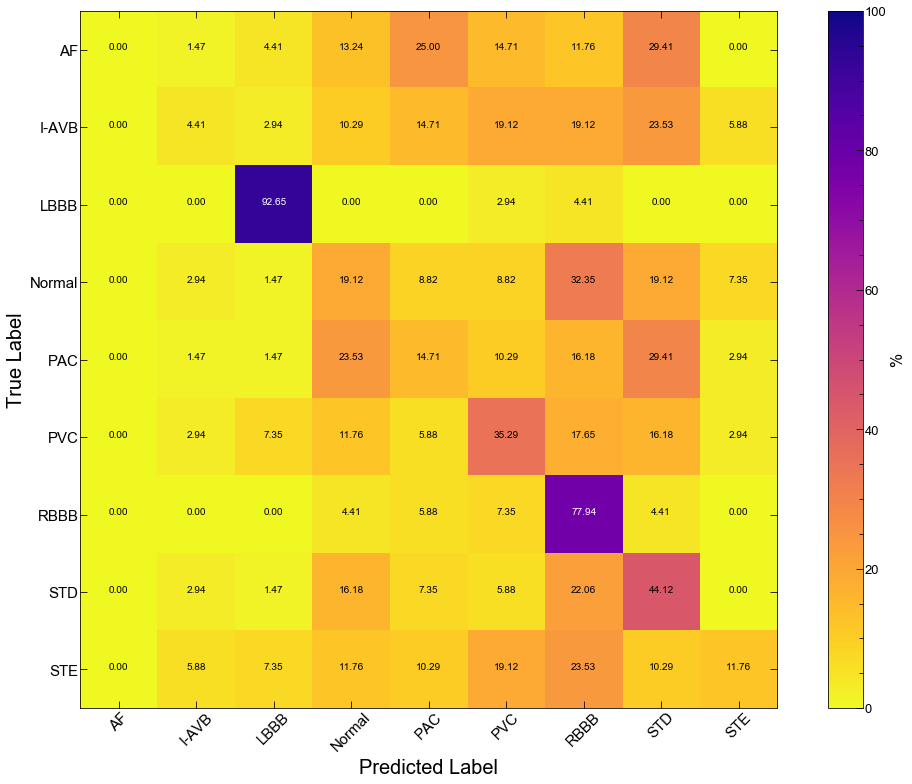

In [28]:
# from common_code import *

plot_confusion_matrix(conf_matrix, label_names=idx_to_class.values(),
                      m_path=output_path, tag='', inline=True,
                      ann_text_std_add=None,
                      normalize=True,
                     )

***
# Dev

In [ ]:
from common_code import *

In [ ]:
# test_mem()